In [1]:
import pandas as pd
import torch
import requests
import gffutils
import numpy as np
import matplotlib.pyplot as plt
import random

import sys
import importlib
import os
sys.path.append("../")


import src.normalization  
importlib.reload(src.normalization)
from src.normalization import size_factor_normalization

from src.sizeFactor import size_factor_expressed
from src.preprocessing import get_gene_length
from src.thetaMethodOfMoments import robust_method_of_moments_theta


import src.pca_init
import src.autoencoder
importlib.reload(src.autoencoder)
importlib.reload(src.pca_init)
from src.pca_init import pca_init
from src.autoencoder import EncoderExpressed, DecoderExpressed, AutoencoderExpressed

torch.set_num_threads(64)


Read the read count matrix (genes x samples) of whole blood tissue

In [2]:



whole_blood_gct ="../data/gene_reads_whole_blood.gct"

df = pd.read_csv(
    whole_blood_gct,
    sep='\t',
    skiprows=2,
    index_col='id',
    dtype={'Name':'category', 'Description':'category'}
)

df.head(10)

,Name,Description,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
id,,,,,,,,,,,,,,,,,,,,,
0,ENSG00000223972.5,DDX11L1,1,1,1,5,1,1,1,3,...,0,3,0,0,2,4,1,0,1,0
1,ENSG00000227232.5,WASH7P,55,70,168,240,47,95,130,71,...,39,146,73,49,101,78,109,171,99,194
2,ENSG00000278267.1,MIR6859-1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,ENSG00000243485.5,MIR1302-2HG,0,0,0,0,0,0,0,1,...,0,0,0,0,2,2,0,0,0,0
4,ENSG00000237613.2,FAM138A,0,0,2,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
5,ENSG00000268020.3,OR4G4P,0,2,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
6,ENSG00000240361.1,OR4G11P,1,0,0,0,3,1,0,1,...,2,3,1,0,0,1,1,0,1,0
7,ENSG00000186092.4,OR4F5,0,1,0,0,0,0,0,0,...,1,2,1,0,0,0,1,1,2,1
8,ENSG00000238009.6,RP11-34P13.7,2,8,3,1,1,2,2,7,...,6,56,20,4,17,2,14,2,3,5


Raw counts of ill datat with GeneID with numerical value

In [3]:
sick_data = "../data/GSE157103_raw_counts_GRCh38.p13_NCBI.tsv"
sick_counts = pd.read_csv(
    sick_data,
    sep='\t',
    index_col="GeneID",
    dtype=str
)

print(sick_counts.shape)

(39376, 126)


Annotations from numerical GeneID to symbol that matches the GTEx data

In [4]:
annot = pd.read_csv(
    "../data/Human.GRCh38.p13.annot.tsv",
    sep='\t',
    dtype=str
)

print(annot.shape)
print(sick_counts.shape)

(39376, 18)
(39376, 126)


In [5]:
symbol_id = (annot[["GeneID", "Symbol"]].drop_duplicates().set_index("GeneID")["Symbol"])
sick_counts.index = sick_counts.index.astype(str) # match the type 



sick_counts["Symbol"] = sick_counts.index.map(symbol_id)
sick_counts = sick_counts.dropna(subset=["Symbol"])
cols = ["Symbol"]+[c for c in sick_counts.columns if c != "Symbol"]
sick_counts = sick_counts[cols]

print(sick_counts.shape)


(39376, 127)


Reading the metadata file from the GTEx website

In [6]:


# URL of the file (right-click the download button and "Copy link address")
url = "https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"

filename_gtex_analysis = "GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"

if not os.path.exists(filename_gtex_analysis):
    print("Downloading file ...")
    
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Check for errors


    with open(filename_gtex_analysis, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("File downloaded successfully!")
else:
    print("Working with local copy")

Working with local copy


Reading the metadata and filtering just the samples from whole blood and getting rid of the ones with RIN smaller than 5.7.

Filter out samples with small RIN from the read-count matrix


In [7]:
meta = pd.read_csv("GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep="\t")


filtered_meta = meta[(meta["SMTSD"] == 'Whole Blood') & (meta["SMRIN"] >=5.7)]


sample_ids = filtered_meta["SAMPID"].tolist()


print(len(sample_ids))


cols_ = ["Name", "Description"]


cols_+= [col for col in df.columns if col in sample_ids]

df_filtered = df[cols_]



print(len(df.columns))

928
757


In [8]:
print(df_filtered.shape)

(56200, 755)


Create database for the gtf file

In [9]:


gtf_file = "../data/gencode.v26.GRCh38.genes.gtf"

dbfn = "genes.db"

if not os.path.exists(dbfn):

    db = gffutils.create_db(gtf_file, dbfn=dbfn, 
                            force=True, keep_order=True, 
                            merge_strategy="merge", 
                            disable_infer_transcripts=True, 
                            disable_infer_genes=True)
else:
    db = gffutils.FeatureDB(dbfn)
    



In [11]:
#df_filtered contains

#from preprocessing import get_gene_length



gene_length = []


for gene in range(len(df_filtered.iloc[:, 2:])):
    gene_id = str(df_filtered.iloc[gene, 0])
    gene_length.append(get_gene_length(gene_id, db))
    
gene_length = np.array(gene_length)




Delete genes that are not contained in the healthy genes 

In [15]:

gene_name = df_filtered[['Name', 'Description']].to_numpy(dtype='str')


healthy_symbol = set(gene_name[:, 1])


sick_counts = sick_counts[sick_counts["Symbol"].isin(healthy_symbol)]
sick_counts_raw = sick_counts.iloc[:, 1:].to_numpy(dtype='float64')
sick_geneids = set(sick_counts.index)



Calculations of fpkm values for the healthy data

In [16]:
sample_lengths = df_filtered.iloc[:, 2:].sum()


raw_counts  = df_filtered.iloc[:, 2:].to_numpy(dtype='float64')



counts_fpkm = raw_counts*1e9


counts_fpkm = counts_fpkm/sample_lengths.values[np.newaxis, :]


counts_fpkm = counts_fpkm/ gene_length[:, np.newaxis]



 




"We then filtered for expressed genes, defined as genes for which at least 5% of the samples had a FPKM value greater than 1 . Additionally, we discarded genes that had zero counts in more than 75% of the samples."



In [17]:
fpkm_theshold = 1

sample_number = counts_fpkm.shape[1]

fpkm_percent = 0.95*sample_number

zero_percent = 0.75*sample_number

mask_fpkm = (counts_fpkm>=fpkm_theshold).sum(axis=1) >= fpkm_percent

mask_zero = (counts_fpkm==0).sum(axis=1) <=zero_percent

expressed_genes = raw_counts[mask_fpkm & mask_zero,:]
expressed_genes_names = gene_name[mask_fpkm & mask_zero,:]

print(expressed_genes.shape)

non_expressed = raw_counts[~(mask_fpkm&mask_zero),:]
non_expressed_names = gene_name[~(mask_fpkm&mask_zero), :]

print(non_expressed.shape)





(6261, 753)
(49939, 753)


Splitting the sick data into expressed and non-expressed genes with the help of the fpkm normalized counts

In [18]:
sick_fpkm  = pd.read_csv(
    "../data/GSE157103_norm_counts_FPKM_GRCh38.p13_NCBI.tsv",
    sep='\t',
    index_col="GeneID"
)
sick_fpkm.index = sick_fpkm.index.astype(str)
print(type(next(iter(sick_fpkm.index))))
print(type(next(iter(sick_geneids))))



sick_fpkm_np = sick_fpkm[sick_fpkm.index.isin(sick_geneids)].to_numpy(dtype='float64')

fpkm_theshold = 1

sample_number = sick_fpkm_np.shape[1]

fpkm_percent = 0.95*sample_number

zero_percent = 0.75*sample_number

mask_fpkm = (sick_fpkm_np>=fpkm_theshold).sum(axis=1) >= fpkm_percent

mask_zero = (sick_fpkm_np==0).sum(axis=1) <=zero_percent

expressed_genes_sick = sick_counts_raw[mask_fpkm & mask_zero,:]


print(expressed_genes_sick.shape)

non_expressed_sick = sick_counts_raw[~(mask_fpkm&mask_zero),:]

print(non_expressed_sick.shape)



<class 'str'>
<class 'str'>
(7307, 126)
(17206, 126)


(5,)


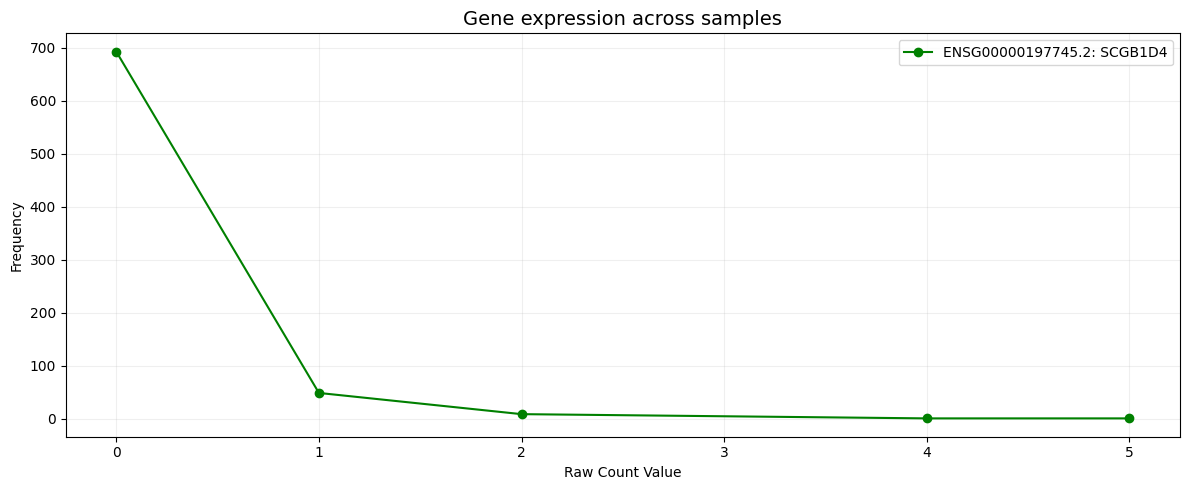

In [19]:


i = random.randint(0, non_expressed.shape[0]-1)
gene_expression = non_expressed[i, :]
unique_counts, frequencies = np.unique(gene_expression, return_counts=True)
print(unique_counts.shape)
gene_id, gene_desc = non_expressed_names[i]

sorted_indices = np.argsort(unique_counts)
unique_counts_sorted = unique_counts[sorted_indices]
frequencies_sorted = frequencies[sorted_indices]

 
plt.figure(figsize=(12, 5))
plt.plot(unique_counts_sorted, frequencies_sorted, color='green', marker='o', label=f"{gene_id}: {gene_desc}")
plt.title("Gene expression across samples", fontsize=14)
plt.xlabel("Raw Count Value", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
# plt.scatter(unique_counts, frequencies, color='green', label=f"{gene_id}: {gene_desc}")
# plt.title("gene expression across samples", fontsize=14)
# plt.xlabel("Expression Count Value", fontsize=10)
# plt.ylabel("Frequency", fontsize=10)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout() 
plt.show()


Calculating the size factors which capture variations in sequencing depth; estimated as the median of the ratios of the gene read counts to their geometric means

In [20]:


print(expressed_genes.shape)

size_factors = size_factor_expressed(expressed_genes)

x, bias = size_factor_normalization(expressed_genes, size_factors)
print(x.shape) 
print(bias.shape)


(6261, 753)
(6261, 753)
(6261, 1)


Plots for checking the  mean-variance relationship for expressed and non expressed 

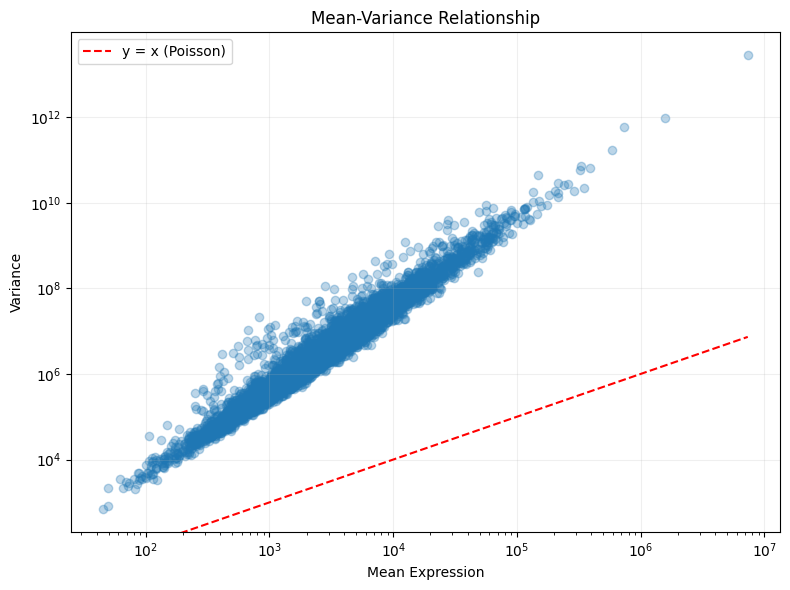

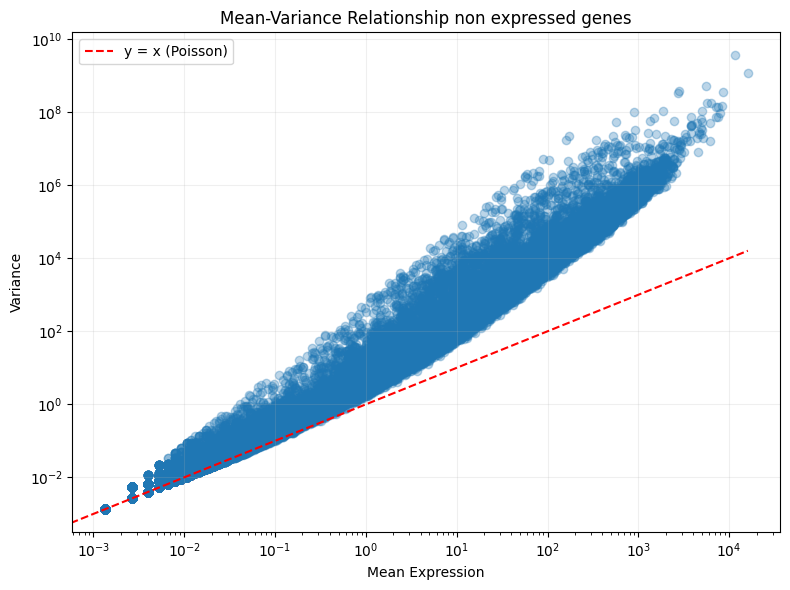

In [21]:



means = expressed_genes.mean(axis=1)
variances = expressed_genes.var(axis=1, ddof=1)

plt.figure(figsize=(8, 6))
plt.scatter(means, variances, alpha=0.3)
plt.plot([0, max(means)], [0, max(means)], 'r--', label='y = x (Poisson)')
plt.xlabel("Mean Expression")
plt.ylabel("Variance")
plt.title("Mean-Variance Relationship")
plt.legend()
plt.grid(alpha=0.2)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()


means = non_expressed.mean(axis=1)
variances = non_expressed.var(axis=1, ddof=1)

plt.figure(figsize=(8, 6))
plt.scatter(means, variances, alpha=0.3)
plt.plot([0, max(means)], [0, max(means)], 'r--', label='y = x (Poisson)')
plt.xlabel("Mean Expression")
plt.ylabel("Variance")
plt.title("Mean-Variance Relationship non expressed genes")
plt.legend()
plt.grid(alpha=0.2)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()




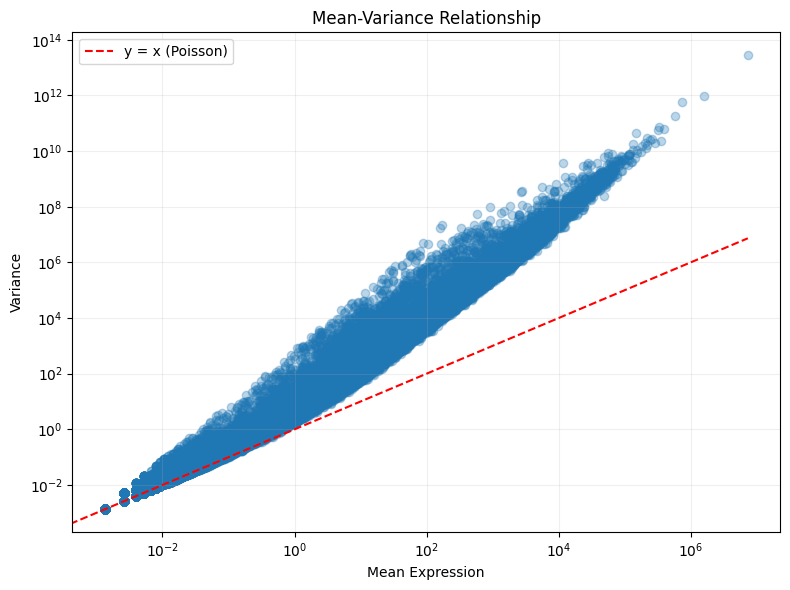

In [22]:



means = raw_counts.mean(axis=1)
variances = raw_counts.var(axis=1, ddof=1)

plt.figure(figsize=(8, 6))
plt.scatter(means, variances, alpha=0.3)
plt.plot([0, max(means)], [0, max(means)], 'r--', label='y = x (Poisson)')
plt.xlabel("Mean Expression")
plt.ylabel("Variance")
plt.title("Mean-Variance Relationship")
plt.legend()
plt.grid(alpha=0.2)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()




Check of zero rates in the non expressed genes

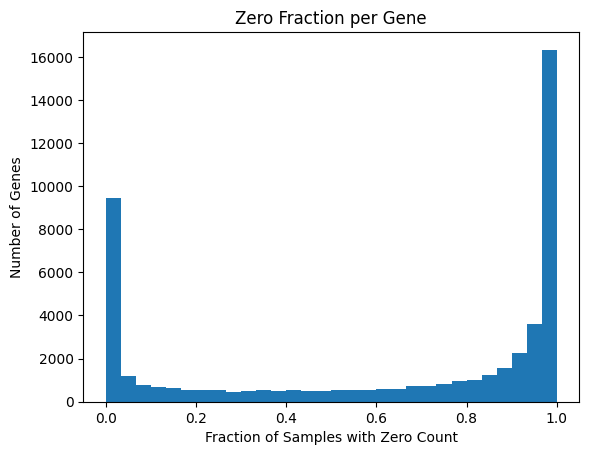

In [23]:
zero_fractions = np.mean(non_expressed == 0, axis=1)
plt.hist(zero_fractions, bins=30)
plt.title("Zero Fraction per Gene")
plt.xlabel("Fraction of Samples with Zero Count")
plt.ylabel("Number of Genes")
plt.show()


In [36]:


#size factors are strictly positive

print(np.sum(size_factors <0)) 

theta = robust_method_of_moments_theta(expressed_genes)

print(np.sum(theta<0))



0
0


Check the sizes of all the initialization matrixes

In [37]:





print(theta.shape)

print(expressed_genes.shape)
print(x.shape)
# print(W_e.shape)
# print(W_d.shape)
print(size_factors.shape)
print(bias.shape)
print(expressed_genes.shape[1])









(6261,)
(6261, 753)
(6261, 753)
(753,)
(6261, 1)
753


Training:   2%|▏         | 1/50 [00:03<02:48,  3.44s/it]

Epoch 0, NLL: 8.264859


Training:   4%|▍         | 2/50 [00:04<01:24,  1.77s/it]

Epoch 1, NLL: 8.240694


Training:   6%|▌         | 3/50 [00:04<00:57,  1.23s/it]

Epoch 2, NLL: 8.219738


Training:   8%|▊         | 4/50 [00:05<00:42,  1.08it/s]

Epoch 3, NLL: 8.201269


Training:  10%|█         | 5/50 [00:05<00:39,  1.13it/s]

Epoch 4, NLL: 8.185067


Training:  12%|█▏        | 6/50 [00:07<00:42,  1.04it/s]

Epoch 5, NLL: 8.171061


Training:  14%|█▍        | 7/50 [00:07<00:39,  1.08it/s]

Epoch 6, NLL: 8.158771


Training:  16%|█▌        | 8/50 [00:08<00:32,  1.28it/s]

Epoch 7, NLL: 8.148262


Training:  18%|█▊        | 9/50 [00:08<00:29,  1.41it/s]

Epoch 8, NLL: 8.138993


Training:  20%|██        | 10/50 [00:09<00:28,  1.41it/s]

Epoch 9, NLL: 8.130791


Training:  22%|██▏       | 11/50 [00:10<00:25,  1.54it/s]

Epoch 10, NLL: 8.123511


Training:  24%|██▍       | 12/50 [00:10<00:22,  1.67it/s]

Epoch 11, NLL: 8.117013


Training:  26%|██▌       | 13/50 [00:11<00:21,  1.75it/s]

Epoch 12, NLL: 8.111190


Training:  28%|██▊       | 14/50 [00:11<00:19,  1.86it/s]

Epoch 13, NLL: 8.105950


Training:  30%|███       | 15/50 [00:11<00:17,  1.97it/s]

Epoch 14, NLL: 8.101290


Training:  32%|███▏      | 16/50 [00:12<00:17,  1.90it/s]

Epoch 15, NLL: 8.097026


Training:  34%|███▍      | 17/50 [00:13<00:18,  1.78it/s]

Epoch 16, NLL: 8.093173


Training:  36%|███▌      | 18/50 [00:13<00:17,  1.88it/s]

Epoch 17, NLL: 8.089761


Training:  38%|███▊      | 19/50 [00:14<00:15,  1.95it/s]

Epoch 18, NLL: 8.086551


Training:  40%|████      | 20/50 [00:14<00:15,  2.00it/s]

Epoch 19, NLL: 8.083660


Training:  42%|████▏     | 21/50 [00:15<00:14,  1.97it/s]

Epoch 20, NLL: 8.081069


Training:  44%|████▍     | 22/50 [00:15<00:14,  1.97it/s]

Epoch 21, NLL: 8.078606


Training:  46%|████▌     | 23/50 [00:16<00:13,  2.00it/s]

Epoch 22, NLL: 8.076424


Training:  48%|████▊     | 24/50 [00:16<00:12,  2.06it/s]

Epoch 23, NLL: 8.074414


Training:  50%|█████     | 25/50 [00:17<00:11,  2.09it/s]

Epoch 24, NLL: 8.072479


Training:  52%|█████▏    | 26/50 [00:17<00:13,  1.77it/s]

Epoch 25, NLL: 8.070809


Training:  54%|█████▍    | 27/50 [00:18<00:12,  1.79it/s]

Epoch 26, NLL: 8.069197


Training:  56%|█████▌    | 28/50 [00:18<00:11,  1.89it/s]

Epoch 27, NLL: 8.067698


Training:  58%|█████▊    | 29/50 [00:19<00:10,  1.91it/s]

Epoch 28, NLL: 8.066361


Training:  60%|██████    | 30/50 [00:19<00:11,  1.81it/s]

Epoch 29, NLL: 8.065123


Training:  62%|██████▏   | 31/50 [00:20<00:10,  1.79it/s]

Epoch 30, NLL: 8.063891


Training:  64%|██████▍   | 32/50 [00:21<00:10,  1.69it/s]

Epoch 31, NLL: 8.062796


Training:  66%|██████▌   | 33/50 [00:21<00:09,  1.80it/s]

Epoch 32, NLL: 8.061830


Training:  68%|██████▊   | 34/50 [00:22<00:09,  1.68it/s]

Epoch 33, NLL: 8.060862


Training:  70%|███████   | 35/50 [00:23<00:09,  1.63it/s]

Epoch 34, NLL: 8.059916


Training:  72%|███████▏  | 36/50 [00:23<00:09,  1.51it/s]

Epoch 35, NLL: 8.059052


Training:  74%|███████▍  | 37/50 [00:24<00:07,  1.67it/s]

Epoch 36, NLL: 8.058147


Training:  76%|███████▌  | 38/50 [00:24<00:06,  1.82it/s]

Epoch 37, NLL: 8.057457


Training:  78%|███████▊  | 39/50 [00:25<00:06,  1.76it/s]

Epoch 38, NLL: 8.056619


Training:  80%|████████  | 40/50 [00:26<00:06,  1.44it/s]

Epoch 39, NLL: 8.055875


Training:  82%|████████▏ | 41/50 [00:27<00:06,  1.34it/s]

Epoch 40, NLL: 8.055140


Training:  84%|████████▍ | 42/50 [00:27<00:05,  1.38it/s]

Epoch 41, NLL: 8.054497


Training:  86%|████████▌ | 43/50 [00:28<00:04,  1.53it/s]

Epoch 42, NLL: 8.053832


Training:  88%|████████▊ | 44/50 [00:28<00:03,  1.53it/s]

Epoch 43, NLL: 8.053208


Training:  90%|█████████ | 45/50 [00:29<00:03,  1.66it/s]

Epoch 44, NLL: 8.052692


Training:  92%|█████████▏| 46/50 [00:30<00:02,  1.67it/s]

Epoch 45, NLL: 8.052157


Training:  94%|█████████▍| 47/50 [00:30<00:01,  1.64it/s]

Epoch 46, NLL: 8.051580


Training:  96%|█████████▌| 48/50 [00:31<00:01,  1.72it/s]

Epoch 47, NLL: 8.051115


Training:  98%|█████████▊| 49/50 [00:31<00:00,  1.82it/s]

Epoch 48, NLL: 8.050549


Training: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]

Epoch 49, NLL: 8.050148


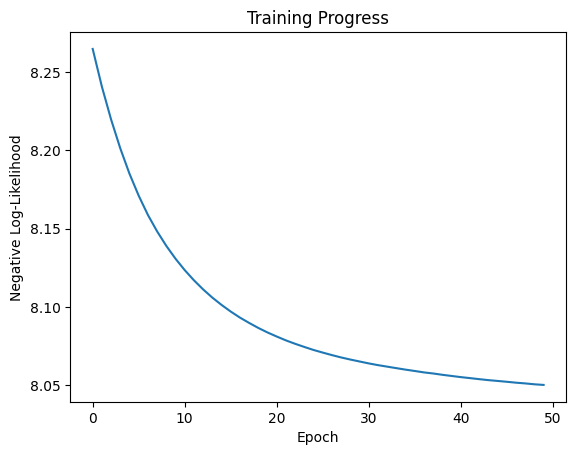

In [38]:

torch.set_num_threads(120)
import sys
import importlib
import os
sys.path.append("../")

importlib.reload(src.autoencoder)
from src.autoencoder import EncoderExpressed, DecoderExpressed, AutoencoderExpressed

latent_dimension = 16

W_e, W_d = pca_init(expressed_genes.T, latent_dimension)


encoder_16 = EncoderExpressed(expressed_genes.shape[0], W_e.T, latent_dimension)

decoder_16 = DecoderExpressed(W_d.T, bias, expressed_genes.shape[0], latent_dimension)



autoencoder_16 = AutoencoderExpressed(encoder=encoder_16, decoder=decoder_16, theta=theta, size_factors=size_factors)

X = torch.tensor(x.T, dtype=torch.float32)
K = torch.tensor(expressed_genes.T, dtype=torch.float32)

loss = autoencoder_16.fit(X, K, n_epochs=50)


loss_values = [l.detach().cpu().item() for l in loss]

plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training Progress")
plt.show()

In [39]:


import sys
import importlib
import os
sys.path.append("../")
from src import getDimension
importlib.reload(src.getDimension)
importlib.reload(src.normalization)
from src.normalization import size_factor_normalization
from src.getDimension import inject_outliers, compute_auc_pr, compute_pvalues

outlier_matrix, mask = inject_outliers(expressed_genes, size_factors=size_factors)

outlier_matrix_norm, _ = size_factor_normalization(outlier_matrix, size_factors)

outliers = torch.tensor(outlier_matrix_norm.T, dtype=torch.float32)









In [40]:
import sys
import importlib
import os
sys.path.append("../")

importlib.reload(src.getDimension)
from src.getDimension import compute_auc_pr, compute_pvalues

mu_trained = autoencoder_16.get_mu(autoencoder_16.forward(outliers)).detach().cpu().numpy().T

theta_trained = autoencoder_16.get_theta().detach().cpu().numpy()


pvals = compute_pvalues(outlier_matrix, mu_trained, theta_trained)

auc_16 = compute_auc_pr(mask.flatten(), pvals.flatten())
print(auc_16)

0.9999118016795742


Training:   2%|▏         | 1/50 [00:00<00:29,  1.69it/s]

Epoch 0, NLL: 8.194646


Training:   4%|▍         | 2/50 [00:01<00:25,  1.85it/s]

Epoch 1, NLL: 8.155943


Training:   6%|▌         | 3/50 [00:01<00:24,  1.89it/s]

Epoch 2, NLL: 8.127958


Training:   8%|▊         | 4/50 [00:02<00:25,  1.83it/s]

Epoch 3, NLL: 8.107918


Training:  10%|█         | 5/50 [00:02<00:24,  1.80it/s]

Epoch 4, NLL: 8.093030


Training:  12%|█▏        | 6/50 [00:03<00:23,  1.88it/s]

Epoch 5, NLL: 8.082064


Training:  14%|█▍        | 7/50 [00:03<00:22,  1.92it/s]

Epoch 6, NLL: 8.073592


Training:  16%|█▌        | 8/50 [00:04<00:22,  1.88it/s]

Epoch 7, NLL: 8.066948


Training:  18%|█▊        | 9/50 [00:04<00:21,  1.87it/s]

Epoch 8, NLL: 8.061579


Training:  20%|██        | 10/50 [00:05<00:21,  1.86it/s]

Epoch 9, NLL: 8.057085


Training:  22%|██▏       | 11/50 [00:05<00:20,  1.88it/s]

Epoch 10, NLL: 8.053418


Training:  24%|██▍       | 12/50 [00:06<00:19,  1.90it/s]

Epoch 11, NLL: 8.050275


Training:  26%|██▌       | 13/50 [00:06<00:19,  1.90it/s]

Epoch 12, NLL: 8.047491


Training:  28%|██▊       | 14/50 [00:07<00:19,  1.89it/s]

Epoch 13, NLL: 8.045287


Training:  30%|███       | 15/50 [00:08<00:20,  1.70it/s]

Epoch 14, NLL: 8.043159


Training:  32%|███▏      | 16/50 [00:08<00:19,  1.76it/s]

Epoch 15, NLL: 8.041436


Training:  34%|███▍      | 17/50 [00:09<00:18,  1.76it/s]

Epoch 16, NLL: 8.039620


Training:  36%|███▌      | 18/50 [00:09<00:18,  1.74it/s]

Epoch 17, NLL: 8.037720


Training:  38%|███▊      | 19/50 [00:10<00:17,  1.76it/s]

Epoch 18, NLL: 8.036220


Training:  40%|████      | 20/50 [00:10<00:16,  1.86it/s]

Epoch 19, NLL: 8.034663


Training:  42%|████▏     | 21/50 [00:11<00:15,  1.83it/s]

Epoch 20, NLL: 8.033229


Training:  44%|████▍     | 22/50 [00:12<00:15,  1.79it/s]

Epoch 21, NLL: 8.031668


Training:  46%|████▌     | 23/50 [00:12<00:15,  1.77it/s]

Epoch 22, NLL: 8.030123


Training:  48%|████▊     | 24/50 [00:13<00:14,  1.84it/s]

Epoch 23, NLL: 8.029003


Training:  50%|█████     | 25/50 [00:13<00:13,  1.81it/s]

Epoch 24, NLL: 8.028126


Training:  52%|█████▏    | 26/50 [00:14<00:13,  1.80it/s]

Epoch 25, NLL: 8.026812


Training:  54%|█████▍    | 27/50 [00:14<00:12,  1.81it/s]

Epoch 26, NLL: 8.026261


Training:  56%|█████▌    | 28/50 [00:15<00:12,  1.78it/s]

Epoch 27, NLL: 8.025916


Training:  58%|█████▊    | 29/50 [00:15<00:11,  1.79it/s]

Epoch 28, NLL: 8.025268


Training:  60%|██████    | 30/50 [00:16<00:11,  1.80it/s]

Epoch 29, NLL: 8.024363


Training:  62%|██████▏   | 31/50 [00:17<00:10,  1.75it/s]

Epoch 30, NLL: 8.023479


Training:  64%|██████▍   | 32/50 [00:17<00:10,  1.73it/s]

Epoch 31, NLL: 8.022804


Training:  66%|██████▌   | 33/50 [00:18<00:09,  1.82it/s]

Epoch 32, NLL: 8.022109


Training:  68%|██████▊   | 34/50 [00:18<00:08,  1.86it/s]

Epoch 33, NLL: 8.021685


Training:  70%|███████   | 35/50 [00:19<00:08,  1.84it/s]

Epoch 34, NLL: 8.020831


Training:  72%|███████▏  | 36/50 [00:19<00:07,  1.80it/s]

Epoch 35, NLL: 8.020669


Training:  74%|███████▍  | 37/50 [00:20<00:06,  1.88it/s]

Epoch 36, NLL: 8.020494


Training:  76%|███████▌  | 38/50 [00:20<00:06,  1.90it/s]

Epoch 37, NLL: 8.020409


Training:  78%|███████▊  | 39/50 [00:21<00:06,  1.82it/s]

Epoch 38, NLL: 8.020268


Training:  80%|████████  | 40/50 [00:21<00:05,  1.82it/s]

Epoch 39, NLL: 8.019480


Training:  82%|████████▏ | 41/50 [00:22<00:04,  1.84it/s]

Epoch 40, NLL: 8.018821


Training:  84%|████████▍ | 42/50 [00:23<00:04,  1.83it/s]

Epoch 41, NLL: 8.018290


Training:  86%|████████▌ | 43/50 [00:23<00:03,  1.87it/s]

Epoch 42, NLL: 8.018066


Training:  88%|████████▊ | 44/50 [00:24<00:03,  1.84it/s]

Epoch 43, NLL: 8.017504


Training:  88%|████████▊ | 44/50 [00:24<00:03,  1.78it/s]

Epoch 44, NLL: 8.017513
Converged at epoch 44 (ΔNLL < 1e-05)


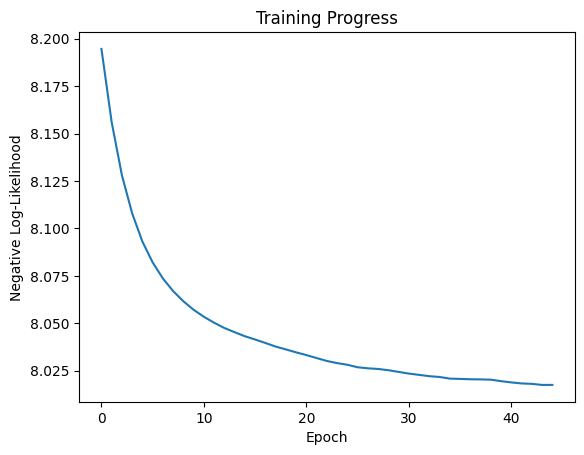

0.9999061256955378


In [29]:

torch.set_num_threads(64)
import sys
import importlib
import os
sys.path.append("../")

importlib.reload(src.autoencoder)
from src.autoencoder import EncoderExpressed, DecoderExpressed, AutoencoderExpressed

latent_dimension = 64

W_e, W_d = pca_init(expressed_genes.T, latent_dimension)


encoder_64 = EncoderExpressed(expressed_genes.shape[0], W_e.T, latent_dimension)

decoder_64 = DecoderExpressed(W_d.T, bias, expressed_genes.shape[0], latent_dimension)



autoencoder_64 = AutoencoderExpressed(encoder=encoder_64, decoder=decoder_64, theta=theta, size_factors=size_factors)

X = torch.tensor(x.T, dtype=torch.float32)
K = torch.tensor(expressed_genes.T, dtype=torch.float32)

loss = autoencoder_64.fit(X, K, n_epochs=50)


loss_values = [l.detach().cpu().item() for l in loss]

plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training Progress")
plt.show()

importlib.reload(src.getDimension)
from src.getDimension import compute_auc_pr, compute_pvalues

mu_trained_64 = autoencoder_64.get_mu(autoencoder_64.forward(outliers)).detach().cpu().numpy().T

theta_trained_64 = autoencoder_64.get_theta().detach().cpu().numpy()


pvals = compute_pvalues(outlier_matrix, mu_trained_64, theta_trained_64)

auc_64 = compute_auc_pr(mask.flatten(), pvals.flatten())

print(auc_64)

In [44]:
import sys
import importlib
import os

import src.sizeFactor
import src.thetaMethodOfMoments
sys.path.append("../")

importlib.reload(src.sizeFactor)
from src.sizeFactor import size_factor_expressed
importlib.reload(src.thetaMethodOfMoments)
from src.thetaMethodOfMoments import robust_method_of_moments_theta 
importlib.reload(src.autoencoder)
from src.autoencoder import AutoencoderExpressed

size_factors_sick = size_factor_expressed(expressed_genes_sick)
theta = robust_method_of_moments_theta(expressed_genes_sick)

Z = autoencoder_16.get_latent(torch.tensor(expressed_genes_sick.T, dtype=torch.float32)).detach().cpu().numpy()
print(Z.shape)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (126x7307 and 6261x16)